---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiante: **María José Gutiérrez Pol**
- Carné: **B83679**
- Estudiante: **Susan Moraga López**
- Carné: **B75140**

- Grupo: **2**

## Proyecto 5 - Simulación de un sistema M/M/1

Es menester tomar una decisión con respecto al número de "servidores" necesarios para cierto proceso de vacunación, de forma tal que el sistema no exceda 50 personas en fila durante el 95% del tiempo de servicio. 

En un estudio de afluencia y del tiempo de servicio se asumen y determinan los siguientes parámetros:

- La tasa de llegada $\lambda$ es constante durante ocho horas de funcionamiento y tiene un valor de $\lambda = 4$ personas por minuto.

- La tasa de servicio $\nu$ de cada "servidor" (es decir, personal de salud tomando datos y vacunando) es constante durante ocho horas de funcionamiento y tiene un valor de $\nu = 0.25$ personas por minuto.

## Parte A - Determinación del número de servidores

El parámetro de umbral de ruptura a utilizar para esta situación corresponde a cuando el sistema llega a las 51 personas. Entonces, como en el anterior ejemplo, se tiene la siguiente expresión:

$$
P( \text{51 o más clientes en el sistema} ) = \sum_{i=51}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{50} (1 - \rho) \rho^i = \rho^{51}
$$

Y se sabe que $\rho$ corresponde a:

$$
\rho = \frac{\lambda}{s \cdot \nu}
$$

Por lo que se tiene la siguiente expresión:
$$
P( \text{51 o más clientes en el sistema} ) = \left ( \frac{\lambda}{s \cdot \nu} \right )^{51}
$$

Se sabe también que esta condición de ruptura aplica para el 95 % del tiempo, por lo que:

$$
\left ( \frac{\lambda}{s \cdot \nu} \right )^{51} \leq \ 0.05
$$

De esta manera, se despeja para encontrar $s$ que corresponde al número de servidores igualando a 0.05. Para ello se utiliza: $\lambda = 4$ y $\nu = 0.25$:

$$
\left ( \frac{\lambda}{s \cdot \nu} \right )^{51} = \ 0.05
$$

$$
\rightarrow \sqrt[51]{0.05} = \frac{\lambda}{s \cdot \nu}
$$


$$
\rightarrow s = \frac{\lambda}{\sqrt[51]{0.05} \cdot \nu}
$$

$$
\rightarrow s = \frac{4}{\sqrt[51]{0.05} \cdot 0.25} = 16.97 
$$

Por lo que se requieren al menos 17 servidores.

In [2]:
#Parte B - Simulación

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def vacunacion(numero):
    
    # Número de clientes
    N = 1000

    # Parámetro de llegada (clientes/segundos)
    lam = 4/60

    # Parámetro de servicio (servicios/segundos)
    nu = 0.25/60

    #Número de servidores

    s = numero

    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale = 1/lam)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale = 1/nu)

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    #Se establecen vectores con tiempos de fin de servicio de cada servidor-------------------------
    servidores = np.zeros(s)

    # Inicialización del tiempo de inicio y fin de atención para el primer cliente
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida

    #Se requiere hacer la asignación del primer cliente
    servidores[0] = fin

    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]
    for i in range(1, N):
        desocupados = np.where(servidores <= t_llegadas[i])[0]
        if desocupados.size == 0:
            inicio = min(servidores) + 1
            fin = inicio + t_servicio[i]
            #Asignar servidor
            c = servidores.tolist().index(min(servidores))
            servidores[c] = fin
        else:
            inicio = t_llegadas[i]
            fin = inicio + t_servicio[i]
            #Asignar servidor
            c = desocupados[0]
            servidores[c] = fin

        t_atencion.append(inicio.astype(int))

    #------------------------------------------------------------------------

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_atencion[-1] + max(t_servicio) + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_atencion[c] + t_servicio[c]
        t[j] -= 1

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 51

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P: 
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
    print('\t {:0.2f}%'.format(100*fraccion))
    if fraccion <= 0.01:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.') 
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, 5000))
    plt.show()

Parámetro lambda = 4.0
Parámetro nu = 0.25
Tiempo con más de 49 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 4.82 horas.


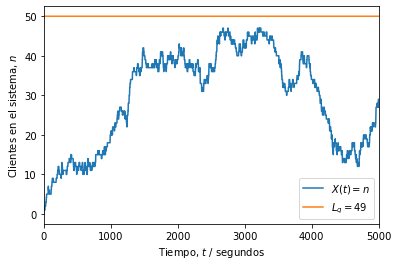

In [21]:
#Simulación para 17 servidores

vacunacion(17)

Parámetro lambda = 4.0
Parámetro nu = 0.25
Tiempo con más de 49 solicitudes en fila:
	 68.52%
	 No cumple con la especificación.
Simulación es equivalente a 4.78 horas.


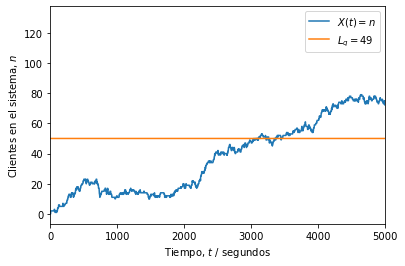

In [13]:
#Simulación para 16 servidores

vacunacion(16)

Como se puede observar del las simulaciones realizadas para los diferentes casos, la cantidad mínima de servidores necesarios corresponden a 17 ya que cumple con la especificación dada y no sobrepasa el valor de umbral a diferencia del segundo caso simulado.

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---